# Testing CNN classification models on the dataset

## The dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# importing sound classification models from torchaudio
import torchaudio

import matplotlib.pyplot as plt
import tqdm

In [2]:
# List the available devices:
print("Available devices:")
print(torch.cuda.device_count())
print("List of devices:")
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.device(1))
print(torch.cuda.get_device_name(1))
device_ids = [0, 1]

Available devices:
2
List of devices:
Tesla T4
Tesla T4


In [3]:
# using gpus if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # to use both GPUs


In [4]:
# Loading the dataset
## Structure of the dataset is as follows:
### dataset_folder -> Folder_name_of_one_class -> audio_file.wav
dataset_folder = '/kaggle/input/trainset/TrainSet'
animals_folder = dataset_folder + '/Animals'+'/animals_segmented'
music_folder = dataset_folder + '/Music'+'/instruments_segmented'
sot_folder = dataset_folder + '/SoT'+'/sound_of_things_segmented'

In [5]:
# Putting the data paths into dictionaries (key: class, value: list of file names)
data_paths = {
    'animals': [os.path.join(animals_folder, file) for file in os.listdir(animals_folder)],
    'music': [os.path.join(music_folder, file) for file in os.listdir(music_folder)],
    'sot': [os.path.join(sot_folder, file) for file in os.listdir(sot_folder)]
}

animals_dict = {
    "animals": 0,
    "music": 1,
    "sot": 2
}

# print len of each class
print(len(data_paths['animals']))
print(len(data_paths['music']))
print(len(data_paths['sot']))
print("Total number of files: ", len(data_paths['animals']) + len(data_paths['music']) + len(data_paths['sot']))

print(data_paths['animals'][:5])

447
504
454
Total number of files:  1405
['/kaggle/input/trainset/TrainSet/Animals/animals_segmented/YIAXl7VjxHAM.wav', '/kaggle/input/trainset/TrainSet/Animals/animals_segmented/YF4XKK8D22rY.wav', '/kaggle/input/trainset/TrainSet/Animals/animals_segmented/YO7SINEL58Ms.wav', '/kaggle/input/trainset/TrainSet/Animals/animals_segmented/Y8d3WbkLC7Gw.wav', '/kaggle/input/trainset/TrainSet/Animals/animals_segmented/Y2dazr-GBSFY.wav']


In [6]:
# Tuple to tensor of numbers
def name_tuple_to_float_tensor(tuple):
    # Read the content of the tupe and use animals_dict to convert the class name to a number in a new tensor
    return torch.tensor([animals_dict[tuple[i]] for i in range(len(tuple))], dtype=torch.float32)

In [7]:
import torch
from torch.utils.data import Dataset
num_classes = 3
class AudioDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.classes = list(data_paths.keys())
        self.files = sum([data_paths[cls] for cls in self.classes], [])
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        for cls in self.classes:
            if idx < len(self.data_paths[cls]):
                file = self.data_paths[cls][idx]
                classe = cls
                break
            idx -= len(self.data_paths[cls])
        else:
            raise IndexError('Index out of range')

        waveform, sample_rate = torchaudio.load(file)
        if self.transform:
            mfcc = self.transform(waveform)
        
        if True:
            # Taking a mean tensor of the mfcc 2 channel tensor
            mfcc = torch.mean(mfcc, dim=0)
        return mfcc, sample_rate, classe

In [8]:
transforms = torchaudio.transforms.MFCC(
    sample_rate= 48000,
    n_mfcc=40, # number of M
    melkwargs={
        'n_fft': 400,
        'hop_length': 160,
        'n_mels': 128
    })

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [9]:
dataset = AudioDataset(data_paths, transform=transforms)
mfcctensor, sample_rate, classe = dataset.__getitem__(0)
print(mfcctensor.shape, sample_rate, classe)

print(mfcctensor)

torch.Size([40, 3001]) 48000 animals
tensor([[-200.8563, -362.0678, -412.4749,  ..., -336.3416, -275.5495,
         -178.4266],
        [ -59.0096,  -29.2521,  -37.6446,  ...,   -2.6386,  -23.1018,
          -21.0079],
        [-117.4281,  -86.6991,  -74.0724,  ...,  -69.4863,  -87.2835,
         -104.7252],
        ...,
        [ -10.2031,   -6.8450,   -2.0041,  ...,  -15.8154,  -12.6054,
           -8.6286],
        [  -9.6286,   -9.0642,   -4.9298,  ...,    2.9605,  -10.7959,
          -18.6853],
        [  -5.3229,    3.0649,    7.8135,  ...,    2.7072,   -1.5437,
          -10.1137]])


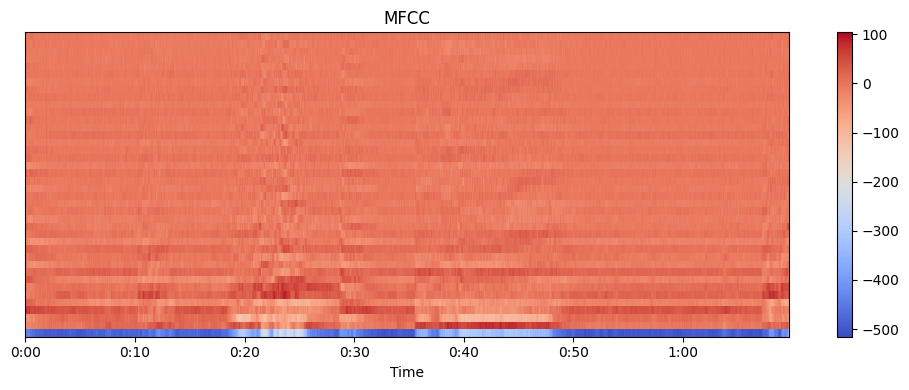

In [10]:
import librosa.display
import matplotlib.pyplot as plt

# Select one channel of the MFCC tensor
mfcc_channel_1 = mfcctensor.detach().numpy() # mfcctensor[0].detach().numpy()

# Plot the MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_channel_1, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [11]:
# Create a dataloader
#audio_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

BATCH_SIZE = 32

# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(len(train_dataset) + len(val_dataset) + len(test_dataset))

# Create dataloaders for the training, validation and test sets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# get the first element of the dataloader
dataiter = iter(train_dataloader)
mfcctensor, sample_rate, classe = next(dataiter)
print(mfcctensor.shape, sample_rate, classe)


1124 140 141
1405
torch.Size([32, 40, 3001]) tensor([48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000]) ('sot', 'music', 'animals', 'animals', 'sot', 'animals', 'music', 'music', 'animals', 'sot', 'animals', 'music', 'animals', 'sot', 'music', 'sot', 'music', 'animals', 'animals', 'music', 'animals', 'animals', 'sot', 'music', 'music', 'animals', 'sot', 'sot', 'sot', 'animals', 'sot', 'music')


In [12]:
torch.cuda.empty_cache()

### Simple CNN model

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.conv2 = nn.Conv2d(12, 64, kernel_size=5)
        self.fc1 = nn.Linear(334656, 3)  # Adjust the parameters here to match the original model

    def forward(self, x):
        #print(x.shape)
        x = x.unsqueeze(1)  # Add a channel dimension
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        #print(x.shape)
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print(x.shape)
        x = self.fc1(x)  # Replace with your desired activation function
        return F.log_softmax(x, dim=1)

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=334656, out_features=3, bias=True)
)


In [14]:
# Instantiate the model and move it to the GPU if available
model = SimpleCNN()
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()
EPOCH = 50
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

loss_evolution = []
accuracy_evolution = []

# Training loop
for epoch in tqdm.trange(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        inputs = inputs.cuda()
        labels = torch.tensor([animals_dict[label] for label in labels]).cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_evolution.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Accuracy computation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _, labels = data
            inputs = inputs.cuda()
            labels = torch.tensor([animals_dict[label] for label in labels]).cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()

    accuracy_evolution.append(100 * correct / total)
    print('[%d] loss: %.3f | Accuracy: %d %%' % (epoch + 1, running_loss / len(train_dataloader), 100 * correct / total))

print('Finished Training')


  2%|▏         | 1/50 [01:23<1:08:12, 83.52s/it]

[1] loss: 2.489 | Accuracy: 31 %


  4%|▍         | 2/50 [02:10<49:41, 62.12s/it]  

[2] loss: 1.237 | Accuracy: 51 %


  6%|▌         | 3/50 [02:58<43:25, 55.43s/it]

[3] loss: 1.127 | Accuracy: 50 %


  8%|▊         | 4/50 [03:44<39:51, 51.99s/it]

[4] loss: 0.980 | Accuracy: 52 %


 10%|█         | 5/50 [04:31<37:36, 50.14s/it]

[5] loss: 0.976 | Accuracy: 52 %


 12%|█▏        | 6/50 [05:18<35:49, 48.85s/it]

[6] loss: 0.892 | Accuracy: 56 %


 14%|█▍        | 7/50 [06:05<34:38, 48.34s/it]

[7] loss: 0.836 | Accuracy: 53 %


 16%|█▌        | 8/50 [06:52<33:30, 47.87s/it]

[8] loss: 0.770 | Accuracy: 52 %


 18%|█▊        | 9/50 [07:39<32:35, 47.70s/it]

[9] loss: 0.730 | Accuracy: 52 %


 20%|██        | 10/50 [08:25<31:32, 47.31s/it]

[10] loss: 0.691 | Accuracy: 59 %


 22%|██▏       | 11/50 [09:12<30:40, 47.19s/it]

[11] loss: 0.651 | Accuracy: 54 %


 24%|██▍       | 12/50 [09:59<29:47, 47.03s/it]

[12] loss: 0.611 | Accuracy: 55 %


 26%|██▌       | 13/50 [10:46<28:59, 47.01s/it]

[13] loss: 0.574 | Accuracy: 57 %


 28%|██▊       | 14/50 [11:33<28:15, 47.09s/it]

[14] loss: 0.557 | Accuracy: 57 %


 30%|███       | 15/50 [12:20<27:27, 47.06s/it]

[15] loss: 0.526 | Accuracy: 56 %


 32%|███▏      | 16/50 [13:07<26:37, 47.00s/it]

[16] loss: 0.500 | Accuracy: 57 %


 34%|███▍      | 17/50 [13:54<25:50, 47.00s/it]

[17] loss: 0.465 | Accuracy: 57 %


 36%|███▌      | 18/50 [14:41<24:59, 46.86s/it]

[18] loss: 0.443 | Accuracy: 59 %


 38%|███▊      | 19/50 [15:28<24:16, 47.00s/it]

[19] loss: 0.411 | Accuracy: 55 %


 40%|████      | 20/50 [16:15<23:26, 46.87s/it]

[20] loss: 0.415 | Accuracy: 57 %


 42%|████▏     | 21/50 [17:02<22:40, 46.93s/it]

[21] loss: 0.371 | Accuracy: 58 %


 44%|████▍     | 22/50 [17:48<21:49, 46.77s/it]

[22] loss: 0.380 | Accuracy: 58 %


 46%|████▌     | 23/50 [18:35<21:07, 46.94s/it]

[23] loss: 0.332 | Accuracy: 58 %


 48%|████▊     | 24/50 [19:22<20:19, 46.89s/it]

[24] loss: 0.325 | Accuracy: 59 %


 50%|█████     | 25/50 [20:09<19:33, 46.95s/it]

[25] loss: 0.314 | Accuracy: 60 %


 52%|█████▏    | 26/50 [20:56<18:48, 47.00s/it]

[26] loss: 0.320 | Accuracy: 58 %


 54%|█████▍    | 27/50 [21:44<18:06, 47.24s/it]

[27] loss: 0.277 | Accuracy: 57 %


 56%|█████▌    | 28/50 [22:31<17:15, 47.07s/it]

[28] loss: 0.274 | Accuracy: 59 %


 58%|█████▊    | 29/50 [23:18<16:29, 47.10s/it]

[29] loss: 0.256 | Accuracy: 58 %


 60%|██████    | 30/50 [24:05<15:42, 47.14s/it]

[30] loss: 0.240 | Accuracy: 60 %


 62%|██████▏   | 31/50 [24:53<14:57, 47.22s/it]

[31] loss: 0.229 | Accuracy: 56 %


 64%|██████▍   | 32/50 [25:40<14:11, 47.28s/it]

[32] loss: 0.224 | Accuracy: 59 %


 66%|██████▌   | 33/50 [26:27<13:23, 47.25s/it]

[33] loss: 0.214 | Accuracy: 60 %


 68%|██████▊   | 34/50 [27:14<12:33, 47.10s/it]

[34] loss: 0.221 | Accuracy: 58 %


 70%|███████   | 35/50 [28:01<11:44, 46.98s/it]

[35] loss: 0.205 | Accuracy: 61 %


 72%|███████▏  | 36/50 [28:48<10:58, 47.01s/it]

[36] loss: 0.206 | Accuracy: 58 %


 74%|███████▍  | 37/50 [29:36<10:14, 47.26s/it]

[37] loss: 0.178 | Accuracy: 60 %


 76%|███████▌  | 38/50 [30:23<09:26, 47.22s/it]

[38] loss: 0.172 | Accuracy: 57 %


 78%|███████▊  | 39/50 [31:10<08:40, 47.28s/it]

[39] loss: 0.164 | Accuracy: 61 %


 80%|████████  | 40/50 [31:57<07:52, 47.23s/it]

[40] loss: 0.154 | Accuracy: 59 %


 82%|████████▏ | 41/50 [32:45<07:05, 47.32s/it]

[41] loss: 0.150 | Accuracy: 59 %


 84%|████████▍ | 42/50 [33:32<06:17, 47.18s/it]

[42] loss: 0.152 | Accuracy: 58 %


 86%|████████▌ | 43/50 [34:19<05:31, 47.29s/it]

[43] loss: 0.151 | Accuracy: 59 %


 88%|████████▊ | 44/50 [35:07<04:44, 47.35s/it]

[44] loss: 0.137 | Accuracy: 60 %


 90%|█████████ | 45/50 [35:54<03:57, 47.42s/it]

[45] loss: 0.131 | Accuracy: 60 %


 92%|█████████▏| 46/50 [36:42<03:09, 47.47s/it]

[46] loss: 0.125 | Accuracy: 60 %


 94%|█████████▍| 47/50 [37:30<02:23, 47.68s/it]

[47] loss: 0.126 | Accuracy: 60 %


 96%|█████████▌| 48/50 [38:17<01:35, 47.51s/it]

[48] loss: 0.119 | Accuracy: 59 %


 98%|█████████▊| 49/50 [39:05<00:47, 47.49s/it]

[49] loss: 0.109 | Accuracy: 60 %


100%|██████████| 50/50 [39:52<00:00, 47.85s/it]

[50] loss: 0.110 | Accuracy: 60 %
Finished Training


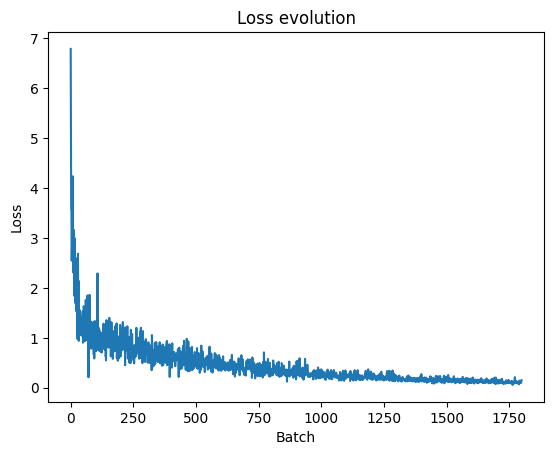

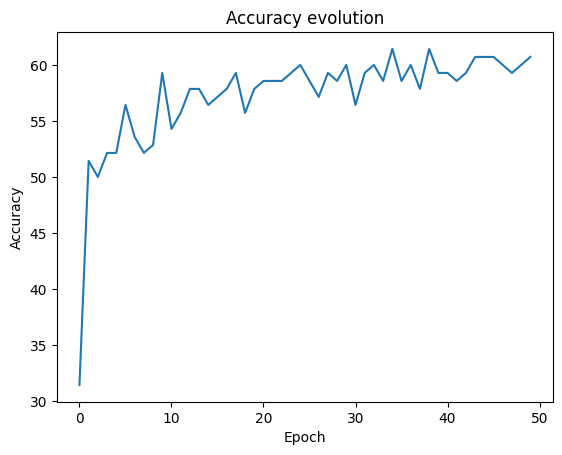

In [15]:
# Plot the loss evolution
plt.plot(loss_evolution)
plt.title('Loss evolution')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy evolution
plt.plot(accuracy_evolution)
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model
torch.save(model.state_dict(), 'simple_cnn.pth')

## Other models

In [16]:
torch.cuda.empty_cache()

In [17]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=edda4823d940699e64d5f0701e64a26497f15d4c382990b8c013fdaa4e3c617b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [18]:
# Importer les modèles nécessaires de torchaudio
# resnet 50, resnet 101
from torchvision.models import resnet50
# efficientnet b0
from efficientnet_pytorch import EfficientNet 

model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
model_resnet50 = resnet50(pretrained=True)
num_classes = 3

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 150MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b0


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


### RESNET50

In [19]:
# Modify the first convolution layer to accept 1 channel instead of 3
model_resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Modify the fully connected layer for your specific task
model_resnet50.fc = nn.Linear(2048, num_classes)

model = model_resnet50
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Training loop
EPOCH = 50

loss_evolution = []
accuracy_evolution = []

for epoch in tqdm.trange(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        inputs = inputs.cuda()
        inputs = inputs.unsqueeze(1)
        labels = torch.tensor([animals_dict[label] for label in labels]).cuda()

        # Transform inputs from tensor of size torch.Size([32, 40, 3001]) to tensor of size torch.Size([32, 3, 40, 3001]) following RVB format
        #inputs = torch.stack([inputs, inputs, inputs], dim=1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss_evolution.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

    # Accuracy computation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _, labels = data
            inputs = inputs.cuda()
            inputs = inputs.unsqueeze(1)
            labels = torch.tensor([animals_dict[label] for label in labels]).cuda()
            #inputs = torch.stack([inputs, inputs, inputs], dim=1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
            

    accuracy_evolution.append(100 * correct / total)
    print('[%d] loss: %.3f | Accuracy: %d %%' % (epoch + 1, running_loss / len(train_dataloader), 100 * correct / total))

  2%|▏         | 1/50 [01:02<51:10, 62.67s/it]

[1] loss: 1.179 | Accuracy: 30 %


  4%|▍         | 2/50 [02:04<49:55, 62.40s/it]

[2] loss: 1.120 | Accuracy: 32 %


  6%|▌         | 3/50 [03:07<48:53, 62.42s/it]

[3] loss: 1.070 | Accuracy: 32 %


  8%|▊         | 4/50 [04:09<47:47, 62.33s/it]

[4] loss: 1.031 | Accuracy: 36 %


 10%|█         | 5/50 [05:11<46:47, 62.38s/it]

[5] loss: 0.986 | Accuracy: 42 %


 12%|█▏        | 6/50 [06:14<45:42, 62.34s/it]

[6] loss: 0.940 | Accuracy: 45 %


 14%|█▍        | 7/50 [07:16<44:34, 62.19s/it]

[7] loss: 0.910 | Accuracy: 50 %


 16%|█▌        | 8/50 [08:17<43:25, 62.03s/it]

[8] loss: 0.876 | Accuracy: 57 %


 18%|█▊        | 9/50 [09:19<42:13, 61.80s/it]

[9] loss: 0.851 | Accuracy: 56 %


 20%|██        | 10/50 [10:20<41:07, 61.70s/it]

[10] loss: 0.829 | Accuracy: 60 %


 22%|██▏       | 11/50 [11:21<40:02, 61.60s/it]

[11] loss: 0.812 | Accuracy: 61 %


 24%|██▍       | 12/50 [12:23<39:02, 61.64s/it]

[12] loss: 0.775 | Accuracy: 65 %


 26%|██▌       | 13/50 [13:25<37:57, 61.56s/it]

[13] loss: 0.754 | Accuracy: 65 %


 28%|██▊       | 14/50 [14:26<36:55, 61.55s/it]

[14] loss: 0.735 | Accuracy: 65 %


 30%|███       | 15/50 [15:28<36:01, 61.76s/it]

[15] loss: 0.731 | Accuracy: 67 %


 32%|███▏      | 16/50 [16:29<34:53, 61.57s/it]

[16] loss: 0.718 | Accuracy: 65 %


 34%|███▍      | 17/50 [17:31<33:53, 61.63s/it]

[17] loss: 0.714 | Accuracy: 65 %


 36%|███▌      | 18/50 [18:33<32:58, 61.81s/it]

[18] loss: 0.680 | Accuracy: 72 %


 38%|███▊      | 19/50 [19:35<31:57, 61.85s/it]

[19] loss: 0.670 | Accuracy: 61 %


 40%|████      | 20/50 [20:37<30:52, 61.76s/it]

[20] loss: 0.675 | Accuracy: 67 %


 42%|████▏     | 21/50 [21:38<29:46, 61.61s/it]

[21] loss: 0.656 | Accuracy: 70 %


 44%|████▍     | 22/50 [22:40<28:43, 61.56s/it]

[22] loss: 0.649 | Accuracy: 66 %


 46%|████▌     | 23/50 [23:41<27:40, 61.49s/it]

[23] loss: 0.655 | Accuracy: 67 %


 48%|████▊     | 24/50 [24:43<26:44, 61.73s/it]

[24] loss: 0.628 | Accuracy: 71 %


 50%|█████     | 25/50 [25:45<25:42, 61.71s/it]

[25] loss: 0.624 | Accuracy: 70 %


 52%|█████▏    | 26/50 [26:47<24:42, 61.77s/it]

[26] loss: 0.601 | Accuracy: 68 %


 54%|█████▍    | 27/50 [27:49<23:44, 61.96s/it]

[27] loss: 0.598 | Accuracy: 69 %


 56%|█████▌    | 28/50 [28:50<22:36, 61.66s/it]

[28] loss: 0.597 | Accuracy: 72 %


 58%|█████▊    | 29/50 [29:51<21:29, 61.42s/it]

[29] loss: 0.595 | Accuracy: 71 %


 60%|██████    | 30/50 [30:53<20:28, 61.44s/it]

[30] loss: 0.584 | Accuracy: 73 %


 62%|██████▏   | 31/50 [31:54<19:26, 61.40s/it]

[31] loss: 0.564 | Accuracy: 72 %


 64%|██████▍   | 32/50 [32:55<18:24, 61.39s/it]

[32] loss: 0.563 | Accuracy: 72 %


 66%|██████▌   | 33/50 [33:56<17:21, 61.27s/it]

[33] loss: 0.540 | Accuracy: 71 %


 68%|██████▊   | 34/50 [34:57<16:19, 61.20s/it]

[34] loss: 0.556 | Accuracy: 77 %


 70%|███████   | 35/50 [35:58<15:15, 61.05s/it]

[35] loss: 0.530 | Accuracy: 70 %


 72%|███████▏  | 36/50 [36:59<14:14, 61.02s/it]

[36] loss: 0.542 | Accuracy: 73 %


 74%|███████▍  | 37/50 [38:00<13:14, 61.13s/it]

[37] loss: 0.539 | Accuracy: 73 %


 76%|███████▌  | 38/50 [39:01<12:13, 61.09s/it]

[38] loss: 0.494 | Accuracy: 75 %


 78%|███████▊  | 39/50 [40:02<11:11, 61.07s/it]

[39] loss: 0.496 | Accuracy: 71 %


 80%|████████  | 40/50 [41:04<10:11, 61.13s/it]

[40] loss: 0.479 | Accuracy: 72 %


 82%|████████▏ | 41/50 [42:05<09:10, 61.13s/it]

[41] loss: 0.487 | Accuracy: 73 %


 84%|████████▍ | 42/50 [43:05<08:07, 60.99s/it]

[42] loss: 0.492 | Accuracy: 72 %


 86%|████████▌ | 43/50 [44:07<07:09, 61.29s/it]

[43] loss: 0.458 | Accuracy: 74 %


 88%|████████▊ | 44/50 [45:10<06:09, 61.62s/it]

[44] loss: 0.471 | Accuracy: 72 %


 90%|█████████ | 45/50 [46:10<05:06, 61.35s/it]

[45] loss: 0.456 | Accuracy: 69 %


 92%|█████████▏| 46/50 [47:12<04:05, 61.32s/it]

[46] loss: 0.453 | Accuracy: 70 %


 94%|█████████▍| 47/50 [48:13<03:04, 61.43s/it]

[47] loss: 0.428 | Accuracy: 72 %


 96%|█████████▌| 48/50 [49:14<02:02, 61.07s/it]

[48] loss: 0.432 | Accuracy: 74 %


 98%|█████████▊| 49/50 [50:15<01:01, 61.01s/it]

[49] loss: 0.425 | Accuracy: 75 %


100%|██████████| 50/50 [51:16<00:00, 61.53s/it]

[50] loss: 0.413 | Accuracy: 72 %


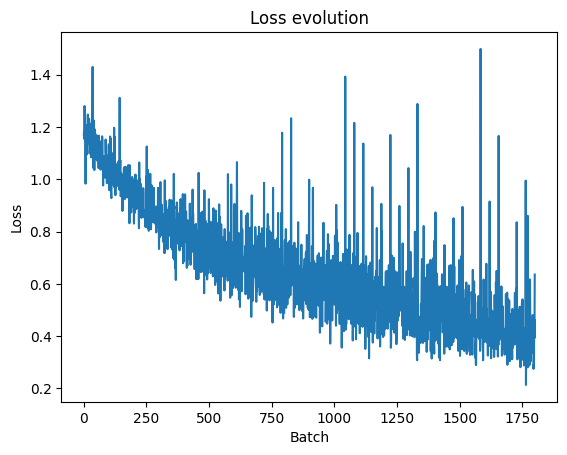

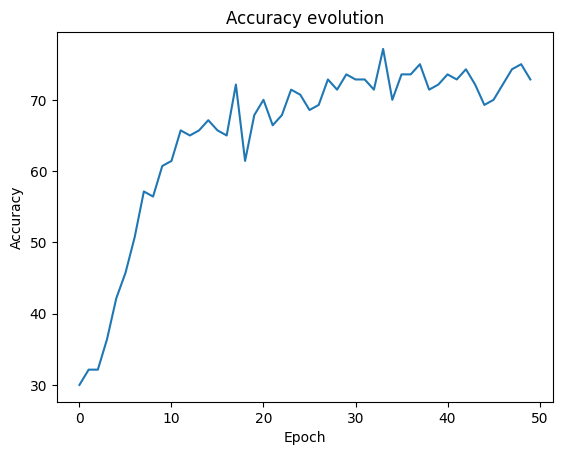

In [20]:
# Plot the loss evolution
plt.plot(loss_evolution)
plt.title('Loss evolution')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy evolution
plt.plot(accuracy_evolution)
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model
torch.save(model.state_dict(), 'resnet50_model.pth')

### EFFICIENTNETB0

In [21]:
torch.cuda.empty_cache()

In [22]:
# Load the EfficientNet model (you need to install the effnet_pytorch library)
model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
# Modify the first convolution layer to accept 1 channel instead of 3
model_efficientnet._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)
# Modify the fully connected layer for your specific task
model_efficientnet._fc = nn.Linear(model_efficientnet._fc.in_features, num_classes)

model = model_efficientnet
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=1e-5)

# Training loop
EPOCH = 30

loss_evolution = []
accuracy_evolution = []

for epoch in tqdm.trange(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        inputs = inputs.cuda()
        labels = torch.tensor([animals_dict[label] for label in labels]).cuda()

        # Add a channel dimension to the input
        inputs = inputs.unsqueeze(1)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss_evolution.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Accuracy computation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _, labels = data
            inputs = inputs.cuda()
            labels = torch.tensor([animals_dict[label] for label in labels]).cuda()
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()

    accuracy_evolution.append(100 * correct / total)
    print('[%d] loss: %.3f | Accuracy: %d %%' % (epoch + 1, running_loss / len(train_dataloader), 100 * correct / total))


Loaded pretrained weights for efficientnet-b0


  3%|▎         | 1/30 [00:55<27:01, 55.91s/it]

[1] loss: 1.098 | Accuracy: 40 %


  7%|▋         | 2/30 [01:51<25:54, 55.52s/it]

[2] loss: 1.055 | Accuracy: 52 %


 10%|█         | 3/30 [02:46<24:55, 55.37s/it]

[3] loss: 1.014 | Accuracy: 60 %


 13%|█▎        | 4/30 [03:41<24:00, 55.41s/it]

[4] loss: 0.976 | Accuracy: 62 %


 17%|█▋        | 5/30 [04:37<23:06, 55.44s/it]

[5] loss: 0.943 | Accuracy: 67 %


 20%|██        | 6/30 [05:32<22:11, 55.46s/it]

[6] loss: 0.899 | Accuracy: 61 %


 23%|██▎       | 7/30 [06:28<21:19, 55.62s/it]

[7] loss: 0.857 | Accuracy: 64 %


 27%|██▋       | 8/30 [07:24<20:24, 55.64s/it]

[8] loss: 0.831 | Accuracy: 66 %


 30%|███       | 9/30 [08:19<19:25, 55.51s/it]

[9] loss: 0.812 | Accuracy: 62 %


 33%|███▎      | 10/30 [09:14<18:28, 55.43s/it]

[10] loss: 0.777 | Accuracy: 68 %


 37%|███▋      | 11/30 [10:11<17:37, 55.63s/it]

[11] loss: 0.768 | Accuracy: 65 %


 40%|████      | 12/30 [11:06<16:41, 55.62s/it]

[12] loss: 0.739 | Accuracy: 70 %


 43%|████▎     | 13/30 [12:02<15:47, 55.74s/it]

[13] loss: 0.706 | Accuracy: 68 %


 47%|████▋     | 14/30 [12:58<14:53, 55.82s/it]

[14] loss: 0.706 | Accuracy: 70 %


 50%|█████     | 15/30 [13:53<13:54, 55.60s/it]

[15] loss: 0.701 | Accuracy: 72 %


 53%|█████▎    | 16/30 [14:49<12:58, 55.59s/it]

[16] loss: 0.698 | Accuracy: 70 %


 57%|█████▋    | 17/30 [15:44<12:01, 55.47s/it]

[17] loss: 0.686 | Accuracy: 69 %


 60%|██████    | 18/30 [16:40<11:09, 55.76s/it]

[18] loss: 0.652 | Accuracy: 65 %


 63%|██████▎   | 19/30 [17:36<10:11, 55.57s/it]

[19] loss: 0.649 | Accuracy: 69 %


 67%|██████▋   | 20/30 [18:31<09:14, 55.49s/it]

[20] loss: 0.620 | Accuracy: 68 %


 70%|███████   | 21/30 [19:26<08:17, 55.33s/it]

[21] loss: 0.610 | Accuracy: 70 %


 73%|███████▎  | 22/30 [20:21<07:22, 55.37s/it]

[22] loss: 0.614 | Accuracy: 67 %


 77%|███████▋  | 23/30 [21:17<06:28, 55.50s/it]

[23] loss: 0.593 | Accuracy: 67 %


 80%|████████  | 24/30 [22:12<05:31, 55.33s/it]

[24] loss: 0.592 | Accuracy: 67 %


 83%|████████▎ | 25/30 [23:08<04:37, 55.42s/it]

[25] loss: 0.579 | Accuracy: 70 %


 87%|████████▋ | 26/30 [24:03<03:41, 55.43s/it]

[26] loss: 0.595 | Accuracy: 74 %


 90%|█████████ | 27/30 [24:59<02:46, 55.64s/it]

[27] loss: 0.573 | Accuracy: 77 %


 93%|█████████▎| 28/30 [25:54<01:51, 55.52s/it]

[28] loss: 0.549 | Accuracy: 74 %


 97%|█████████▋| 29/30 [26:50<00:55, 55.46s/it]

[29] loss: 0.559 | Accuracy: 73 %


100%|██████████| 30/30 [27:46<00:00, 55.54s/it]

[30] loss: 0.538 | Accuracy: 74 %


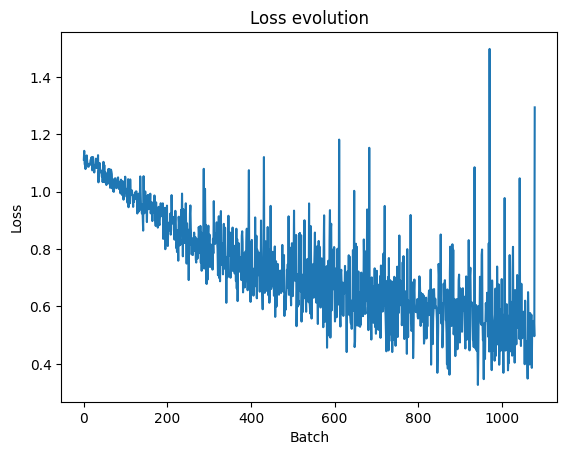

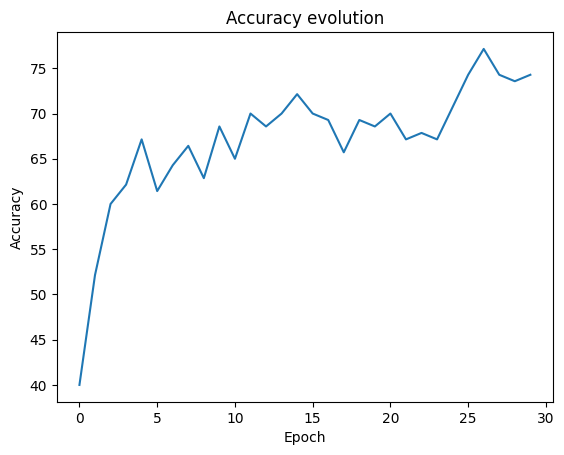

In [23]:
# Plot the loss evolution
plt.plot(loss_evolution)
plt.title('Loss evolution')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy evolution
plt.plot(accuracy_evolution)
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model
torch.save(model.state_dict(), 'efficientnet_model.pth')

### RESNET101

In [24]:
torch.cuda.empty_cache()

In [25]:
from torchvision.models import resnet101
model_resnet101 = resnet101(pretrained=True)

# Modify the first convolution layer to accept 1 channel instead of 3
model_resnet101.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the fully connected layer for your specific task
model_resnet101.fc = nn.Linear(model_resnet101.fc.in_features, num_classes)

model = model_resnet101
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)

# Training loop
EPOCH = 50

loss_evolution = []
accuracy_evolution = []

for epoch in tqdm.trange(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        inputs = inputs.cuda()
        labels = torch.tensor([animals_dict[label] for label in labels]).cuda()

        # Add a channel dimension to the input
        inputs = inputs.unsqueeze(1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss_evolution.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        break

    # Accuracy computation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _, labels = data
            inputs = inputs.cuda()
            labels = torch.tensor([animals_dict[label] for label in labels]).cuda()
            # Add a channel dimension to the input
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
            break

    accuracy_evolution.append(100 * correct / total)
    print('[%d] loss: %.3f | Accuracy: %d %%' % (epoch + 1, running_loss / len(train_dataloader), 100 * correct / total))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 132MB/s]
  2%|▏         | 1/50 [00:03<02:42,  3.32s/it]

[1] loss: 0.029 | Accuracy: 40 %


  4%|▍         | 2/50 [00:06<02:36,  3.26s/it]

[2] loss: 0.030 | Accuracy: 46 %


  6%|▌         | 3/50 [00:09<02:34,  3.29s/it]

[3] loss: 0.031 | Accuracy: 46 %


  8%|▊         | 4/50 [00:13<02:36,  3.39s/it]

[4] loss: 0.030 | Accuracy: 37 %


 10%|█         | 5/50 [00:16<02:30,  3.34s/it]

[5] loss: 0.031 | Accuracy: 40 %


 12%|█▏        | 6/50 [00:19<02:26,  3.33s/it]

[6] loss: 0.030 | Accuracy: 37 %


 14%|█▍        | 7/50 [00:23<02:21,  3.30s/it]

[7] loss: 0.029 | Accuracy: 43 %


 16%|█▌        | 8/50 [00:26<02:17,  3.28s/it]

[8] loss: 0.032 | Accuracy: 21 %


 18%|█▊        | 9/50 [00:29<02:14,  3.29s/it]

[9] loss: 0.031 | Accuracy: 28 %


 20%|██        | 10/50 [00:33<02:11,  3.29s/it]

[10] loss: 0.031 | Accuracy: 46 %


 22%|██▏       | 11/50 [00:36<02:10,  3.33s/it]

[11] loss: 0.031 | Accuracy: 28 %


 24%|██▍       | 12/50 [00:39<02:08,  3.37s/it]

[12] loss: 0.030 | Accuracy: 37 %


 26%|██▌       | 13/50 [00:43<02:03,  3.33s/it]

[13] loss: 0.035 | Accuracy: 50 %


 28%|██▊       | 14/50 [00:46<02:00,  3.36s/it]

[14] loss: 0.030 | Accuracy: 31 %


 30%|███       | 15/50 [00:49<01:56,  3.32s/it]

[15] loss: 0.031 | Accuracy: 21 %


 32%|███▏      | 16/50 [00:53<01:52,  3.31s/it]

[16] loss: 0.030 | Accuracy: 21 %


 34%|███▍      | 17/50 [00:56<01:48,  3.28s/it]

[17] loss: 0.030 | Accuracy: 37 %


 36%|███▌      | 18/50 [00:59<01:44,  3.28s/it]

[18] loss: 0.030 | Accuracy: 34 %


 38%|███▊      | 19/50 [01:03<01:43,  3.33s/it]

[19] loss: 0.032 | Accuracy: 40 %


 40%|████      | 20/50 [01:06<01:39,  3.33s/it]

[20] loss: 0.030 | Accuracy: 37 %


 42%|████▏     | 21/50 [01:09<01:38,  3.38s/it]

[21] loss: 0.031 | Accuracy: 40 %


 44%|████▍     | 22/50 [01:13<01:35,  3.40s/it]

[22] loss: 0.031 | Accuracy: 46 %


 46%|████▌     | 23/50 [01:16<01:33,  3.45s/it]

[23] loss: 0.030 | Accuracy: 43 %


 48%|████▊     | 24/50 [01:20<01:28,  3.42s/it]

[24] loss: 0.031 | Accuracy: 34 %


 50%|█████     | 25/50 [01:23<01:24,  3.39s/it]

[25] loss: 0.029 | Accuracy: 40 %


 52%|█████▏    | 26/50 [01:26<01:20,  3.36s/it]

[26] loss: 0.031 | Accuracy: 40 %


 54%|█████▍    | 27/50 [01:30<01:17,  3.36s/it]

[27] loss: 0.034 | Accuracy: 43 %


 56%|█████▌    | 28/50 [01:33<01:13,  3.34s/it]

[28] loss: 0.030 | Accuracy: 40 %


 58%|█████▊    | 29/50 [01:36<01:10,  3.35s/it]

[29] loss: 0.031 | Accuracy: 40 %


 60%|██████    | 30/50 [01:40<01:06,  3.34s/it]

[30] loss: 0.031 | Accuracy: 34 %


 62%|██████▏   | 31/50 [01:43<01:02,  3.30s/it]

[31] loss: 0.031 | Accuracy: 43 %


 64%|██████▍   | 32/50 [01:46<01:00,  3.33s/it]

[32] loss: 0.029 | Accuracy: 43 %


 66%|██████▌   | 33/50 [01:50<00:56,  3.33s/it]

[33] loss: 0.031 | Accuracy: 37 %


 68%|██████▊   | 34/50 [01:53<00:52,  3.30s/it]

[34] loss: 0.030 | Accuracy: 46 %


 70%|███████   | 35/50 [01:56<00:49,  3.27s/it]

[35] loss: 0.030 | Accuracy: 31 %


 72%|███████▏  | 36/50 [01:59<00:45,  3.26s/it]

[36] loss: 0.031 | Accuracy: 40 %


 74%|███████▍  | 37/50 [02:03<00:42,  3.28s/it]

[37] loss: 0.029 | Accuracy: 31 %


 76%|███████▌  | 38/50 [02:06<00:39,  3.27s/it]

[38] loss: 0.030 | Accuracy: 25 %


 78%|███████▊  | 39/50 [02:09<00:36,  3.31s/it]

[39] loss: 0.032 | Accuracy: 46 %


 80%|████████  | 40/50 [02:13<00:32,  3.30s/it]

[40] loss: 0.032 | Accuracy: 40 %


 82%|████████▏ | 41/50 [02:16<00:29,  3.29s/it]

[41] loss: 0.030 | Accuracy: 37 %


 84%|████████▍ | 42/50 [02:19<00:27,  3.40s/it]

[42] loss: 0.032 | Accuracy: 31 %


 86%|████████▌ | 43/50 [02:23<00:23,  3.39s/it]

[43] loss: 0.031 | Accuracy: 31 %


 88%|████████▊ | 44/50 [02:26<00:20,  3.35s/it]

[44] loss: 0.030 | Accuracy: 43 %


 90%|█████████ | 45/50 [02:29<00:16,  3.32s/it]

[45] loss: 0.030 | Accuracy: 34 %


 92%|█████████▏| 46/50 [02:33<00:13,  3.33s/it]

[46] loss: 0.030 | Accuracy: 31 %


 94%|█████████▍| 47/50 [02:36<00:09,  3.30s/it]

[47] loss: 0.030 | Accuracy: 31 %


 96%|█████████▌| 48/50 [02:39<00:06,  3.29s/it]

[48] loss: 0.030 | Accuracy: 31 %


 98%|█████████▊| 49/50 [02:42<00:03,  3.28s/it]

[49] loss: 0.030 | Accuracy: 40 %


100%|██████████| 50/50 [02:46<00:00,  3.32s/it]

[50] loss: 0.030 | Accuracy: 37 %


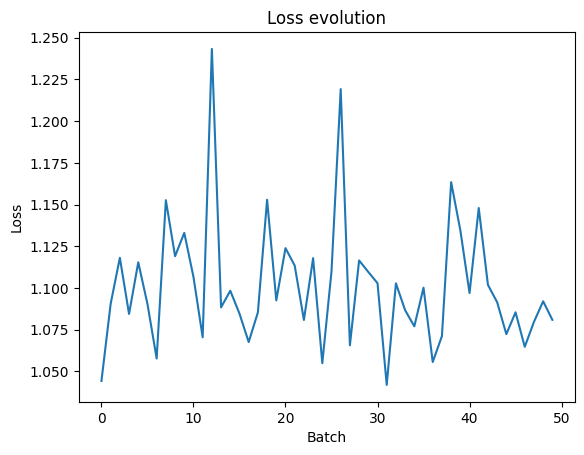

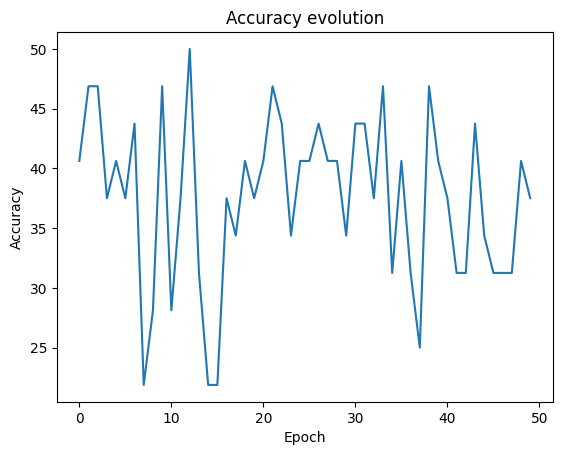

In [26]:
# Plot the loss evolution
plt.plot(loss_evolution)
plt.title('Loss evolution')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy evolution
plt.plot(accuracy_evolution)
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model
torch.save(model.state_dict(), 'resnet101_model.pth')

### VGG16:

In [27]:
torch.cuda.empty_cache()

In [28]:
from torchvision.models import vgg16
model_vgg16 = vgg16(pretrained=True)

# Modify the first convolution layer to accept 1 channel instead of 3
model_vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Modify the fully connected layer for your specific task
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, num_classes)

model = model_vgg16
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
EPOCH = 40

loss_evolution = []
accuracy_evolution = []

for epoch in tqdm.trange(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        inputs = inputs.cuda()
        labels = torch.tensor([animals_dict[label] for label in labels]).cuda()

        # Add a channel dimension to the input
        inputs = inputs.unsqueeze(1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss_evolution.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        break

    # Accuracy computation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _, labels = data
            inputs = inputs.cuda()
            labels = torch.tensor([animals_dict[label] for label in labels]).cuda()
            
            # Add a channel dimension to the input
            inputs = inputs.unsqueeze(1)
        
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
            break

    accuracy_evolution.append(100 * correct / total)
    print('[%d] loss: %.3f | Accuracy: %d %%' % (epoch + 1, running_loss / len(train_dataloader), 100 * correct / total))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 171MB/s]
  2%|▎         | 1/40 [00:03<02:10,  3.35s/it]

[1] loss: 0.053 | Accuracy: 28 %


  5%|▌         | 2/40 [00:06<02:12,  3.49s/it]

[2] loss: 0.050 | Accuracy: 31 %


  8%|▊         | 3/40 [00:10<02:07,  3.44s/it]

[3] loss: 0.043 | Accuracy: 18 %


 10%|█         | 4/40 [00:13<02:02,  3.41s/it]

[4] loss: 0.044 | Accuracy: 34 %


 12%|█▎        | 5/40 [00:17<01:59,  3.42s/it]

[5] loss: 0.032 | Accuracy: 53 %


 15%|█▌        | 6/40 [00:20<01:55,  3.39s/it]

[6] loss: 0.033 | Accuracy: 34 %


 18%|█▊        | 7/40 [00:23<01:51,  3.38s/it]

[7] loss: 0.038 | Accuracy: 34 %


 20%|██        | 8/40 [00:27<01:49,  3.43s/it]

[8] loss: 0.046 | Accuracy: 31 %


 22%|██▎       | 9/40 [00:30<01:47,  3.48s/it]

[9] loss: 0.037 | Accuracy: 46 %


 25%|██▌       | 10/40 [00:34<01:44,  3.47s/it]

[10] loss: 0.036 | Accuracy: 25 %


 28%|██▊       | 11/40 [00:37<01:40,  3.47s/it]

[11] loss: 0.035 | Accuracy: 31 %


 30%|███       | 12/40 [00:41<01:36,  3.46s/it]

[12] loss: 0.039 | Accuracy: 43 %


 32%|███▎      | 13/40 [00:44<01:32,  3.43s/it]

[13] loss: 0.030 | Accuracy: 37 %


 35%|███▌      | 14/40 [00:48<01:29,  3.42s/it]

[14] loss: 0.034 | Accuracy: 40 %


 38%|███▊      | 15/40 [00:51<01:25,  3.41s/it]

[15] loss: 0.033 | Accuracy: 31 %


 40%|████      | 16/40 [00:54<01:22,  3.44s/it]

[16] loss: 0.030 | Accuracy: 25 %


 42%|████▎     | 17/40 [00:58<01:20,  3.50s/it]

[17] loss: 0.021 | Accuracy: 34 %


 45%|████▌     | 18/40 [01:01<01:16,  3.46s/it]

[18] loss: 0.036 | Accuracy: 53 %


 48%|████▊     | 19/40 [01:05<01:12,  3.44s/it]

[19] loss: 0.035 | Accuracy: 43 %


 50%|█████     | 20/40 [01:08<01:08,  3.43s/it]

[20] loss: 0.028 | Accuracy: 25 %


 52%|█████▎    | 21/40 [01:12<01:05,  3.45s/it]

[21] loss: 0.031 | Accuracy: 40 %


 55%|█████▌    | 22/40 [01:15<01:01,  3.42s/it]

[22] loss: 0.026 | Accuracy: 40 %


 57%|█████▊    | 23/40 [01:19<00:58,  3.45s/it]

[23] loss: 0.028 | Accuracy: 43 %


 60%|██████    | 24/40 [01:22<00:54,  3.42s/it]

[24] loss: 0.029 | Accuracy: 46 %


 62%|██████▎   | 25/40 [01:25<00:50,  3.40s/it]

[25] loss: 0.028 | Accuracy: 43 %


 65%|██████▌   | 26/40 [01:29<00:48,  3.47s/it]

[26] loss: 0.026 | Accuracy: 46 %


 68%|██████▊   | 27/40 [01:32<00:44,  3.44s/it]

[27] loss: 0.025 | Accuracy: 40 %


 70%|███████   | 28/40 [01:36<00:41,  3.43s/it]

[28] loss: 0.023 | Accuracy: 62 %


 72%|███████▎  | 29/40 [01:39<00:37,  3.41s/it]

[29] loss: 0.028 | Accuracy: 37 %


 75%|███████▌  | 30/40 [01:42<00:33,  3.40s/it]

[30] loss: 0.030 | Accuracy: 53 %


 78%|███████▊  | 31/40 [01:46<00:30,  3.38s/it]

[31] loss: 0.024 | Accuracy: 59 %


 80%|████████  | 32/40 [01:49<00:27,  3.38s/it]

[32] loss: 0.030 | Accuracy: 53 %


 82%|████████▎ | 33/40 [01:52<00:23,  3.37s/it]

[33] loss: 0.024 | Accuracy: 65 %


 85%|████████▌ | 34/40 [01:56<00:20,  3.36s/it]

[34] loss: 0.028 | Accuracy: 56 %


 88%|████████▊ | 35/40 [01:59<00:16,  3.37s/it]

[35] loss: 0.030 | Accuracy: 53 %


 90%|█████████ | 36/40 [02:03<00:13,  3.46s/it]

[36] loss: 0.028 | Accuracy: 50 %


 92%|█████████▎| 37/40 [02:06<00:10,  3.45s/it]

[37] loss: 0.024 | Accuracy: 46 %


 95%|█████████▌| 38/40 [02:10<00:06,  3.48s/it]

[38] loss: 0.023 | Accuracy: 59 %


 98%|█████████▊| 39/40 [02:13<00:03,  3.44s/it]

[39] loss: 0.029 | Accuracy: 53 %


100%|██████████| 40/40 [02:17<00:00,  3.43s/it]

[40] loss: 0.025 | Accuracy: 46 %


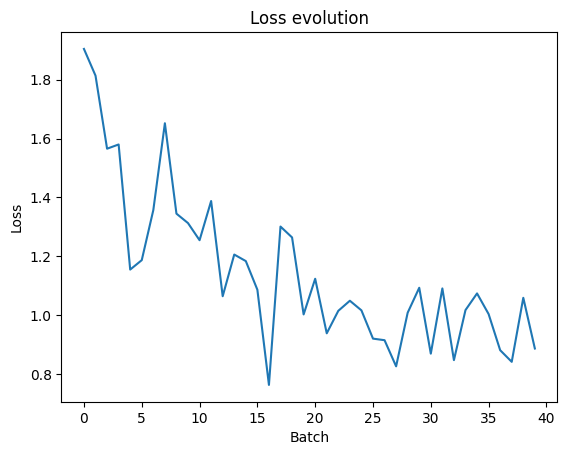

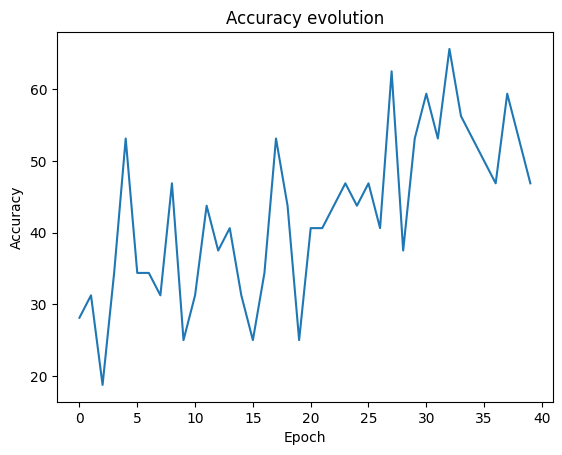

In [29]:
# Plot the loss evolution
plt.plot(loss_evolution)
plt.title('Loss evolution')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy evolution
plt.plot(accuracy_evolution)
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model
torch.save(model.state_dict(), 'resnet101_model.pth')

### Densenet 121

In [30]:
torch.cuda.empty_cache()

In [31]:
from torchvision.models import densenet121
model_densenet121 = densenet121(pretrained=True)

# Modify the first convolution layer to accept 1 channel instead of 3
model_densenet121.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the fully connected layer for your specific task
model_densenet121.classifier = nn.Linear(model_densenet121.classifier.in_features, num_classes)

model = model_densenet121
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCH = 25

loss_evolution = []
accuracy_evolution = []

for epoch in tqdm.trange(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        inputs = inputs.cuda()
        labels = torch.tensor([animals_dict[label] for label in labels]).cuda()

        # Add a channel dimension to the input
        inputs = inputs.unsqueeze(1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss_evolution.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        break

    # Accuracy computation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _, labels = data
            inputs = inputs.cuda()
            labels = torch.tensor([animals_dict[label] for label in labels]).cuda()
            
            # Add a channel dimension to the input
            inputs = inputs.unsqueeze(1)
        
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
            break

    accuracy_evolution.append(100 * correct / total)
    print('[%d] loss: %.3f | Accuracy: %d %%' % (epoch + 1, running_loss / len(train_dataloader), 100 * correct / total))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 128MB/s]
  4%|▍         | 1/25 [00:03<01:13,  3.06s/it]

[1] loss: 0.030 | Accuracy: 53 %


  8%|▊         | 2/25 [00:06<01:08,  2.99s/it]

[2] loss: 0.031 | Accuracy: 34 %


 12%|█▏        | 3/25 [00:08<01:05,  2.98s/it]

[3] loss: 0.029 | Accuracy: 46 %


 16%|█▌        | 4/25 [00:12<01:03,  3.03s/it]

[4] loss: 0.030 | Accuracy: 59 %


 20%|██        | 5/25 [00:15<01:00,  3.04s/it]

[5] loss: 0.025 | Accuracy: 71 %


 24%|██▍       | 6/25 [00:18<00:57,  3.03s/it]

[6] loss: 0.029 | Accuracy: 59 %


 28%|██▊       | 7/25 [00:21<00:54,  3.05s/it]

[7] loss: 0.025 | Accuracy: 68 %


 32%|███▏      | 8/25 [00:24<00:50,  2.99s/it]

[8] loss: 0.023 | Accuracy: 50 %


 36%|███▌      | 9/25 [00:27<00:48,  3.03s/it]

[9] loss: 0.025 | Accuracy: 56 %


 40%|████      | 10/25 [00:30<00:44,  2.98s/it]

[10] loss: 0.018 | Accuracy: 59 %


 44%|████▍     | 11/25 [00:33<00:41,  2.96s/it]

[11] loss: 0.023 | Accuracy: 68 %


 48%|████▊     | 12/25 [00:36<00:38,  2.99s/it]

[12] loss: 0.025 | Accuracy: 56 %


 52%|█████▏    | 13/25 [00:39<00:35,  3.00s/it]

[13] loss: 0.024 | Accuracy: 59 %


 56%|█████▌    | 14/25 [00:41<00:32,  2.96s/it]

[14] loss: 0.022 | Accuracy: 46 %


 60%|██████    | 15/25 [00:45<00:30,  3.01s/it]

[15] loss: 0.021 | Accuracy: 71 %


 64%|██████▍   | 16/25 [00:48<00:27,  3.02s/it]

[16] loss: 0.024 | Accuracy: 62 %


 68%|██████▊   | 17/25 [00:51<00:24,  3.03s/it]

[17] loss: 0.022 | Accuracy: 62 %


 72%|███████▏  | 18/25 [00:54<00:21,  3.03s/it]

[18] loss: 0.025 | Accuracy: 56 %


 76%|███████▌  | 19/25 [00:57<00:18,  3.04s/it]

[19] loss: 0.021 | Accuracy: 53 %


 80%|████████  | 20/25 [01:00<00:14,  2.99s/it]

[20] loss: 0.018 | Accuracy: 65 %


 84%|████████▍ | 21/25 [01:03<00:11,  2.97s/it]

[21] loss: 0.016 | Accuracy: 59 %


 88%|████████▊ | 22/25 [01:05<00:08,  2.94s/it]

[22] loss: 0.015 | Accuracy: 68 %


 92%|█████████▏| 23/25 [01:08<00:05,  2.93s/it]

[23] loss: 0.016 | Accuracy: 81 %


 96%|█████████▌| 24/25 [01:11<00:02,  2.92s/it]

[24] loss: 0.019 | Accuracy: 56 %


100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

[25] loss: 0.020 | Accuracy: 78 %


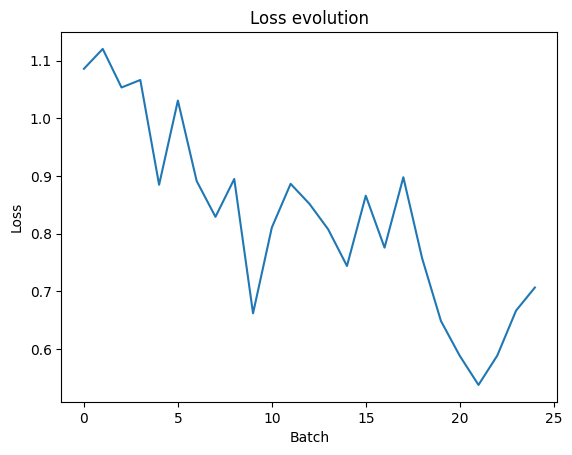

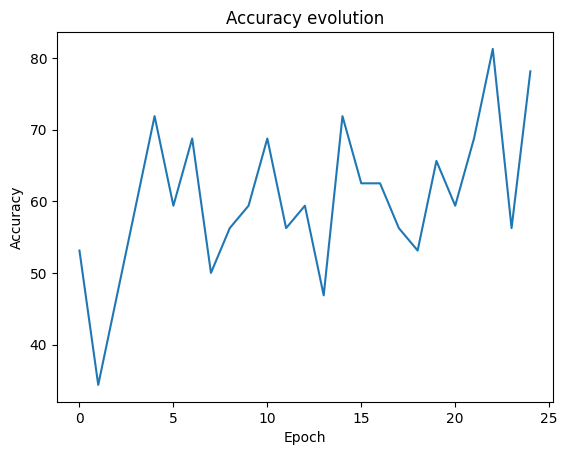

In [32]:
# Plot the loss evolution
plt.plot(loss_evolution)
plt.title('Loss evolution')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy evolution
plt.plot(accuracy_evolution)
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model
torch.save(model.state_dict(), 'resnet101_model.pth')

### MobileNetV2

In [33]:
torch.cuda.empty_cache()

In [34]:
from torchvision.models import mobilenet_v2
model_mobilenetv2 = mobilenet_v2(pretrained=True)

# Modify the first convolution layer to accept 1 channel instead of 3
model_mobilenetv2.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the fully connected layer for your specific task
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.classifier[1].in_features, num_classes)

model = model_mobilenetv2
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCH = 25

loss_evolution = []
accuracy_evolution = []

for epoch in tqdm.trange(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        inputs = inputs.cuda()
        labels = torch.tensor([animals_dict[label] for label in labels]).cuda()

        # Add a channel dimension to the input
        inputs = inputs.unsqueeze(1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss_evolution.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        break

    # Accuracy computation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _, labels = data
            inputs = inputs.cuda()
            labels = torch.tensor([animals_dict[label] for label in labels]).cuda()
            # Add a channel dimension to the input
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
            break

    accuracy_evolution.append(100 * correct / total)
    print('[%d] loss: %.3f | Accuracy: %d %%' % (epoch + 1, running_loss / len(train_dataloader), 100 * correct / total))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 103MB/s] 
  4%|▍         | 1/25 [00:02<01:02,  2.60s/it]

[1] loss: 0.033 | Accuracy: 40 %


  8%|▊         | 2/25 [00:05<00:59,  2.58s/it]

[2] loss: 0.031 | Accuracy: 34 %


 12%|█▏        | 3/25 [00:07<00:56,  2.55s/it]

[3] loss: 0.029 | Accuracy: 50 %


 16%|█▌        | 4/25 [00:10<00:54,  2.60s/it]

[4] loss: 0.028 | Accuracy: 43 %


 20%|██        | 5/25 [00:12<00:51,  2.59s/it]

[5] loss: 0.027 | Accuracy: 71 %


 24%|██▍       | 6/25 [00:15<00:49,  2.60s/it]

[6] loss: 0.025 | Accuracy: 71 %


 28%|██▊       | 7/25 [00:18<00:46,  2.58s/it]

[7] loss: 0.023 | Accuracy: 65 %


 32%|███▏      | 8/25 [00:20<00:43,  2.58s/it]

[8] loss: 0.020 | Accuracy: 62 %


 36%|███▌      | 9/25 [00:23<00:41,  2.60s/it]

[9] loss: 0.022 | Accuracy: 56 %


 40%|████      | 10/25 [00:26<00:39,  2.65s/it]

[10] loss: 0.018 | Accuracy: 68 %


 44%|████▍     | 11/25 [00:28<00:37,  2.67s/it]

[11] loss: 0.022 | Accuracy: 75 %


 48%|████▊     | 12/25 [00:31<00:34,  2.68s/it]

[12] loss: 0.017 | Accuracy: 71 %


 52%|█████▏    | 13/25 [00:34<00:31,  2.67s/it]

[13] loss: 0.031 | Accuracy: 62 %


 56%|█████▌    | 14/25 [00:36<00:28,  2.63s/it]

[14] loss: 0.015 | Accuracy: 71 %


 60%|██████    | 15/25 [00:39<00:26,  2.60s/it]

[15] loss: 0.029 | Accuracy: 71 %


 64%|██████▍   | 16/25 [00:41<00:23,  2.60s/it]

[16] loss: 0.029 | Accuracy: 84 %


 68%|██████▊   | 17/25 [00:44<00:20,  2.58s/it]

[17] loss: 0.014 | Accuracy: 59 %


 72%|███████▏  | 18/25 [00:46<00:17,  2.57s/it]

[18] loss: 0.027 | Accuracy: 75 %


 76%|███████▌  | 19/25 [00:49<00:15,  2.56s/it]

[19] loss: 0.012 | Accuracy: 65 %


 80%|████████  | 20/25 [00:52<00:12,  2.58s/it]

[20] loss: 0.022 | Accuracy: 68 %


 84%|████████▍ | 21/25 [00:54<00:10,  2.58s/it]

[21] loss: 0.020 | Accuracy: 68 %


 88%|████████▊ | 22/25 [00:57<00:07,  2.56s/it]

[22] loss: 0.015 | Accuracy: 56 %


 92%|█████████▏| 23/25 [00:59<00:05,  2.59s/it]

[23] loss: 0.023 | Accuracy: 62 %


 96%|█████████▌| 24/25 [01:02<00:02,  2.64s/it]

[24] loss: 0.019 | Accuracy: 65 %


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]

[25] loss: 0.017 | Accuracy: 62 %


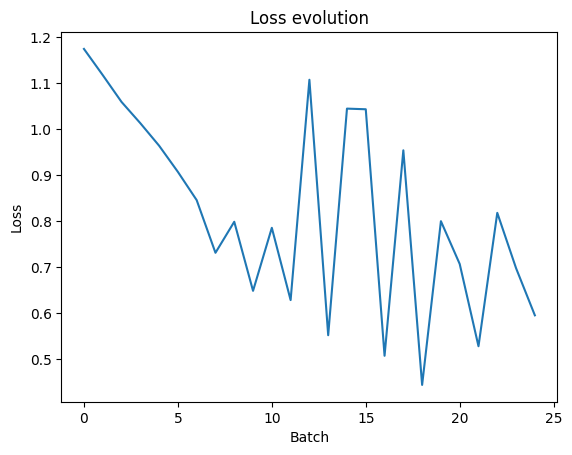

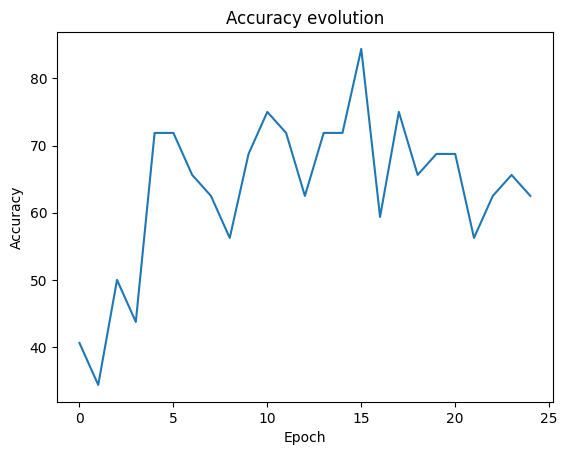

In [35]:
# Plot the loss evolution
plt.plot(loss_evolution)
plt.title('Loss evolution')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Plot the accuracy evolution
plt.plot(accuracy_evolution)
plt.title('Accuracy evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Save the model
torch.save(model.state_dict(), 'resnet101_model.pth')